In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorboard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input

from tensorflow.keras.metrics import Precision, Accuracy
from tensorflow.keras.metrics import SensitivityAtSpecificity, SpecificityAtSensitivity
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.models import Model

In [3]:
img_width, img_height = 224, 224
# Set up the data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Dataset_Clean/Pneumonia_vs_Normal_Final/train', 
                                                    target_size=(img_width, img_height), batch_size=32, 
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Dataset_Clean/Pneumonia_vs_Normal_Final/val', 
                                                  target_size=(img_width, img_height), batch_size=32, 
                                                  class_mode='categorical')

Found 2016 images belonging to 2 classes.
Found 674 images belonging to 2 classes.


In [4]:
train_generator.class_indices

{'Normal': 0, 'Viral_Pneumonia': 1}

In [5]:
# Define the Keras TensorBoard callback.
logdir = "/content/drive/MyDrive/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# To save the training history
csv_logger = CSVLogger("/content/drive/MyDrive/Trainig_History.csv", append=True)

In [6]:
checkpoint_filepath = "/content/drive/MyDrive/CheXNet_Pneumonia_Normal.h5"
SAVE_BEST_ONLY = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=0, 
                                 save_best_only=True, mode='auto')

CALLBACKS = [tensorboard_callback, csv_logger, SAVE_BEST_ONLY]

In [7]:
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))
base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape,pooling="avg")
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
# Load the pre-trained weights
chexnet_model.load_weights("/content/drive/MyDrive/Paper_Codes/CheXNet_Keras_0.3.0_weights.h5")

29084464/29084464 [==============================] - 1s 0us/step


In [8]:
# Remove last 2 layers
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")
new_model = Sequential()
new_model.add(final_chexnet_model)
new_model.add(Dense(2,activation='softmax'))

# Compile the model
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'TruePositives',
                                                                          'TrueNegatives', 'FalsePositives', 'FalseNegatives', 
                                                                          tf.keras.metrics.SpecificityAtSensitivity(0.5), 
                                                                          tf.keras.metrics.SensitivityAtSpecificity(0.5)])
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Chexnet_model (Functional)  (None, 1024)              7037504   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


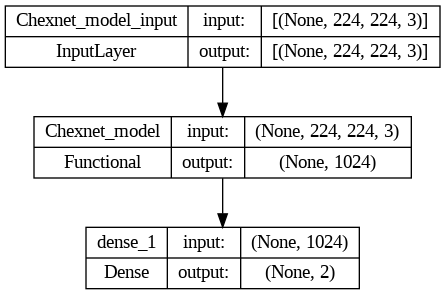

In [ ]:
tf.keras.utils.plot_model(new_model,show_shapes=True,show_layer_names=True,to_file="chex.png") 

In [9]:
history = new_model.fit(train_generator, epochs=8, validation_data=test_generator, callbacks=CALLBACKS)

Epoch 1/8
63/63 [==============================] - 864s 12s/step - loss: 0.2293 - accuracy: 0.9489 - precision: 0.9489 - recall: 0.9489 - true_positives: 1913.0000 - true_negatives: 1913.0000 - false_positives: 103.0000 - false_negatives: 103.0000 - specificity_at_sensitivity: 0.9985 - sensitivity_at_specificity: 0.9985 - val_loss: 0.1455 - val_accuracy: 0.9881 - val_precision: 0.9881 - val_recall: 0.9881 - val_true_positives: 666.0000 - val_true_negatives: 666.0000 - val_false_positives: 8.0000 - val_false_negatives: 8.0000 - val_specificity_at_sensitivity: 1.0000 - val_sensitivity_at_specificity: 1.0000
Epoch 2/8
63/63 [==============================] - 40s 626ms/step - loss: 0.0122 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9950 - true_positives: 2006.0000 - true_negatives: 2006.0000 - false_positives: 10.0000 - false_negatives: 10.0000 - specificity_at_sensitivity: 0.9995 - sensitivity_at_specificity: 0.9995 - val_loss: 0.9900 - val_accuracy: 0.5415 - val_precision: 0.5415 

In [ ]:
# Evaluate the model
loss, accuracy,*_ = new_model.evaluate(test_generator)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = new_model.predict_generator(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)


sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()
